<a href="https://colab.research.google.com/github/armenmatoosian/workshops-from-Myles-H/blob/master/Microcourses/llmsfor.me/notebooks/2_llms_for_me_fine_tuning_quantiation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.nlpfromscratch.com?utm_source=notebook&utm_medium=nb-header"><center><img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/coverimage_PT2.png?raw=1"></center></a>

# Fine-tuning LLMs, PEFT, and Quantization

Copyright, NLP from scratch, 2025.

[LLMSfor.me](https://llmsfor.me)

------------

## Introduction 🎬
In this notebook, we will continue from part 1, and look at fine-tuning Large Language Models (LLMs) for generative text using the open source libraries from [Hugging Face](https://huggingface.co/).

This notebook is best run in [Google Colab](https://colab.research.google.com/), where the majority of dependencies are already installed. However, if you wish to run the notebook locally, please follow the [directions for setting up a local environment](https://drive.google.com/file/d/1EV1seK-dUHRCzj2EDuu3ETAhUyjzOGRd/view?usp=drive_link) and you may then download the notebook as a `.ipynb` and run in either Jupyter or Jupyterlab.

Since we will be using GPU in this notebook for compute-intensive tasks, please ensure that if running on Colab the runtime type is set to GPU. In the menu in Colab, select *Runtime -> Change runtime type*, then select T4 GPU (if using Colab Free) or another GPU instance type if using Colab Pro.

<center><img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/gpu_colab.png?raw=1" width="50%"/></center><br/>

Though Google Colab comes with many useful data science libraries included by default (including Pytorch), the Hugging Face libraries are not, so we will first install those here using `pip`, as they will be used in the remainder of the notebook.

- The `transformers` library, for general usage of transformer models
- The `datasets` library, for working with datasets hosted on Hugging Face
- The `accelerate` library, for using GPU for inference
- The `evaluate` library, for metrics for measuring model performance in training
- The `bitsandbytes` library for model quantization
- The `peft` library, for efficient fine-tuning of models in the second half of the workshop
- The `huggingface_hub` library, for interacting with models on the Hugging Face hub

We will also be using custom datasets from the NLP from scratch [github repo](https://github.com/nlpfromscratch/datasets/) and so we will clone this repo to have these all available locally.



In [ ]:
!git clone https://github.com/nlpfromscratch/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 78, done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 78 (from 1)
Receiving objects: 100% (78/78), 41.86 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (29/29), done.


In [ ]:
!pip install transformers datasets accelerate evaluate bitsandbytes peft huggingface_hub

## Fine-tuning Large Language Models

Now that we have covered some of the fundamentals of working with pre-trained large language models for generative text, we will progress to the more advanced task of adapting pre-trained models to specific tasks or datasets to change their behavior.

Adapting a pre-trained LLM for a new problem or specific dataset by updating its parameters through further training is referred to as [fine-tuning](https://en.wikipedia.org/wiki/Fine-tuning_(deep_learning)). Though the nomenclature has evolved and the terms are now sometimes used interchangeably, this technique is a type of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning). Other methods for transfer learning do exist, and so the term "fine-tuning" should be more specifically use to refer to cases in which model weights are updated (or new model weights are added and optimized) against a new dataset or objective.

In practice, the term *fine-tuning* is more commonly now used with respect to LLMs, while that of *transfer learning* to refer to the larger group of approaches, usually inside the domain of machine learning and deep learning outside of language models.

One of the most common applications for fine-tuning is to take a well-performing pre-trained language model (foundation model) as a base and adapt this to a new classification task. This is commonly done with the [BERT model](https://en.wikipedia.org/wiki/BERT_(language_model) as a base, which has already learned powerful and meaningful representations of language, and adapt it to other NLP tasks, for example, by attaching a classification "head", or even by having another simple classifier model take the outputs of the BERT model as inputs for a classification task.

<center>
<img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/bert_finetune.png?raw=1" width="75%"/>
</center>
<center><caption> Adapting BERT to a new text NLP task via fine-tuning </caption></center>

There is an example of the above, for full fine-tuning of BERT (no frozen layers) in the [Hugging Face documentation](https://huggingface.co/docs/transformers/training#fine-tune-a-pretrained-model).

In the remainder of this workshop, we will focus on fully fine-tuning the GPT-2 model we've been working with already as a "hello world" example, and see if we can change the behavior (outputs) of this generative text model with fine-tuning.

### Fine-tuning a model in Hugging Face using the Trainer API

In this section, we will write our own code to train a model using the Hugging Face library directly. Essentially, HF acts as a higher-level API around pytorch, handling all of the nitty-gritty lower level details of training for us.

Here, we will work with the [Yoda dataset](https://github.com/nlpfromscratch/datasets/tree/master/yoda) to teach a GPT to speak like our favourite Jedi master. In this case, however, we will work directly with Hugging Face's `Trainer` class to fine-tune our model.

<center>
<img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/yoda.png?raw=1" width="150px"/>
</center>

Now, we can load our base model that we wish to fine-tune. Doing this type of work is computationally demanding, so again, please make sure you are using a GPU runtime if you are running this notebook in Colab, or have sufficient computing resources (*i.e.* a GPU) if you are choosing to run the notebook locally.

#### Loading the Data

As with all machine learning, we first need data. The Yoda dataset is conveniently stored in the NLP from scratch [datasets repo](https://github.com/nlpfromscratch/datasets) on Github, which we already pulled down at the beginning of the notebook using `git`.

Let's take a look at the data:

In [ ]:
# Take a look at the yoda data
!ls datasets/yoda/

README.md  yoda.csv


We can see there is one data file, `yoda.csv`. This contains all the lines spoken by Yoda in the Star Wars films. Let's take a look at some of the data we'll be using for fine-tuning a generative text model:

In [13]:
import pandas as pd

# Read
yoda_df = pd.read_csv('datasets/yoda/yoda.csv')

# Show
yoda_df.head()

,text
0,"The very Republic is threatened, if involved t..."
1,"Hard to see, the dark side is. Discover who th..."
2,"With this Naboo queen you must stay, Qui-Gon. ..."
3,May the Force be with you.
4,(Cont'd) Master Qui-Gon more to say have you?


In [14]:
yoda_df.shape

(103, 1)

In total there are 103 lines of dialog we'll be using for fine-tuning our model. As a general rule, pre-training LLMs requires very large datasets and is highly computationally expensive, whereas fine-tuning them requires much smaller datasets and is not.

Now we will import the `load_dataset` function from the `datasets` library, to [load the CSV file](https://huggingface.co/docs/datasets/loading) into a format the Hugging Face expects. We pass a dictionary with a single key, `train` and value of the filename, here `yoda.csv`. We also pass a string of the `dataset_name`, which is the path (directory) where the data reside:

In [15]:
from datasets import load_dataset

data_files = {"train": "yoda.csv"}
dataset_name = 'datasets/yoda/'
dataset = load_dataset(dataset_name, data_files=data_files)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Great, that seems to have worked. Let's do a quick check here and take a look at the dataset object:

In [16]:
# Quick check
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 103
    })
})

In [17]:
type(dataset)

datasets.dataset_dict.DatasetDict

We can see the dataset is a dataset dictionary from the `datasets` library, and contains a single feature, the column `text`. This is suitable for causal langauge modeling, so we may proceed.

#### Loading the Tokenizer and Model

Now that we have the raw data, we need to preprocess it using a tokenizer. Here, we will just be using an [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) and load the that for the base type of model we are using, which in this case is GPT-2.

We also need to load the base model with the original weights, the model that we will be fine-tuning. Since we are doing causal language modeling (*i.e.* text generation), here we will load GPT-2 using the [AutoModelforCausalLM](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) class.

In [18]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

# Use GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Instantiate model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Let's just do a quick check of our tokenizer and model now. First for tokenizing input text:

In [19]:
# Generate inputs for model
input = tokenizer("The rain in Spain", return_tensors="pt").to(device)
print(input)

{'input_ids': tensor([[ 464, 6290,  287, 8602]]), 'attention_mask': tensor([[1, 1, 1, 1]])}


Next, we generate the model outputs by passing the input through the model:

In [20]:
# Generate model outputs
output = model.generate(**input, max_new_tokens=20)
print(output)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[  464,  6290,   287,  8602,   468,   587,   523,  2089,   326,   262,
          1748,   286, 15142,   468,   587,  4137,   284,  1969,   663,  8215,
            13,   198,   198,   464]])


Finally, we decode the model's output token ids back to text:

In [22]:
print(tokenizer.decode(output[0]))

The rain in Spain has been so bad that the city of Barcelona has been forced to close its doors.

The


Great! Everything appears to be working fine. Currently, our input dataset is all freeform text:

In [23]:
dataset['train'][0:5]

{'text': ['The very Republic is threatened, if involved the Sith are.',
  'Hard to see, the dark side is. Discover who this assassin is, we must.',
  'With this Naboo queen you must stay, Qui-Gon. Protect her.',
  'May the Force be with you.',
  "(Cont'd) Master Qui-Gon more to say have you?"]}

We'll need to apply the tokenizer to each record to create a tokenized version to pass into the model as input. This is the name as what we did above, only now we need to do this for each row in the dataset. To do this, we'll create a simple function then apply it over the entire dataset using the `.map` method:

In [24]:
# Add a padding token to the tokenizer (required)
tokenizer.pad_token = tokenizer.eos_token

# Define tokenization function using the already instantiated tokenizer
def tokenize_function(data):
    my_tokenizer = tokenizer(data["text"], padding="max_length", truncation=True, return_tensors="pt", max_length=128)
    return my_tokenizer

# Apply the tokenizer function to each row of data in the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/103 [00:00<?, ? examples/s]

Now if we take a look at our tokenized dataset, we should see each row is a list of input ids for the tokens, plus an attention mask, as expected:

In [25]:
for i in range(0,5):
  print(tokenized_dataset['train'][i])

{'text': 'The very Republic is threatened, if involved the Sith are.', 'input_ids': [464, 845, 2066, 318, 8556, 11, 611, 2950, 262, 26455, 389, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1,

#### Training (Fine-tuning) the Model

Now we can proceed to what we really want to do - fine-tuning the model! First we need to set up a `Trainer` object from Hugging Face, as well as a `TrainingArguments` object. This was being done for us previously in the training script, where each argument we gave to the script was passed along into the Trainer.

We'll also import the `evaluate` package and load the accuracy metric from it, which will be used to evaluate the performance of our model as it is tuned:

In [26]:
from transformers import TrainingArguments, Trainer
import evaluate

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="yoda-gpt2",
    num_train_epochs=10,
    remove_unused_columns=True,
    report_to="none",
    evaluation_strategy="epoch")

# Set up the metric used to evaluate the training
metric = evaluate.load("accuracy")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Here, we need a utility function, called `compute_metrics`, to get the output probabilities (logits) for each token and token labels, then compute the predictions of the most likely token, and finally calculate the accuracy based upon these predictions with respect to the training data:

In [27]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

We'll also need to create a [DataCollator](https://huggingface.co/docs/transformers/main_classes/data_collator) object. What does the data collator do? The data collator takes the input data and creates batches of it to pass into the model. Remember, underneath it all, a large language model is still just a deep learning model, and expects batches of input data for training.

We create the data collator by importing the class from the `transformers` library, then instantiating it and passing the tokenizer object. We also set the argument `mlm=False` here, since we are doing causal language modeling, not masked language modeling:

In [28]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Ok, let's take a look at the collator in action. We can pass it a sample of data from our dataset and take a look at the output:

In [29]:
# Sample text
texts = dataset['train'][0:4]['text']
print("Text:")
print(texts)
print("\n")

# Tokenize
print("Tokenized text:")
tokens = [tokenizer(t) for t in texts]
print(tokens)
print("\n")

# Collate
print("Collated data")

dataloader = torch.utils.data.DataLoader(dataset=tokens, collate_fn=data_collator, batch_size=4)

for batch in dataloader:
    print(batch)
print("\n")

Text:
['The very Republic is threatened, if involved the Sith are.', 'Hard to see, the dark side is. Discover who this assassin is, we must.', 'With this Naboo queen you must stay, Qui-Gon. Protect her.', 'May the Force be with you.']


Tokenized text:
[{'input_ids': [464, 845, 2066, 318, 8556, 11, 611, 2950, 262, 26455, 389, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, {'input_ids': [17309, 284, 766, 11, 262, 3223, 1735, 318, 13, 29704, 508, 428, 31120, 318, 11, 356, 1276, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, {'input_ids': [3152, 428, 36099, 2238, 16599, 345, 1276, 2652, 11, 2264, 72, 12, 38, 261, 13, 21916, 607, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}, {'input_ids': [6747, 262, 5221, 307, 351, 345, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}]


Collated data
{'input_ids': tensor([[  464,   845,  2066,   318,  8556,    11,   611,  2950,   262, 26455,
           389,    13, 50256, 50256

Here we can see that the collator has reformatted the sample data (4 records) into a batch, where each key has an array of the different inputs (`input_ids`, `attention_mask`, and `labels`). We probably don't need to worry about this level of detail, but this is the format the model expects the data in, so we are really just using the data collator to restructure everything.

Finally, we can instantiate a `Trainer` object, passing in the base model to be fine-tuned, the training arguments, datasets for training and evaluation, associated evaluation metric(s), and the data collator, as defined above:

In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["train"],
    data_collator=data_collator,
)

Now that everything is good to go, we can simply call `trainer.train()` and Hugging Face takes care of the rest!

In [32]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,3.594074
2,No log,3.112686


Epoch,Training Loss,Validation Loss
1,No log,3.594074
2,No log,3.112686
3,No log,2.709129
4,No log,2.382526
5,No log,2.139412
6,No log,1.936208
7,No log,1.766858
8,No log,1.652943
9,No log,1.583503
10,No log,1.559851


TrainOutput(global_step=130, training_loss=2.6526775653545673, metrics={'train_runtime': 2772.7944, 'train_samples_per_second': 0.371, 'train_steps_per_second': 0.047, 'total_flos': 67282698240000.0, 'train_loss': 2.6526775653545673, 'epoch': 10.0})

Great! We can visualize the model training (loss), as it is stored in the `Trainer` state:

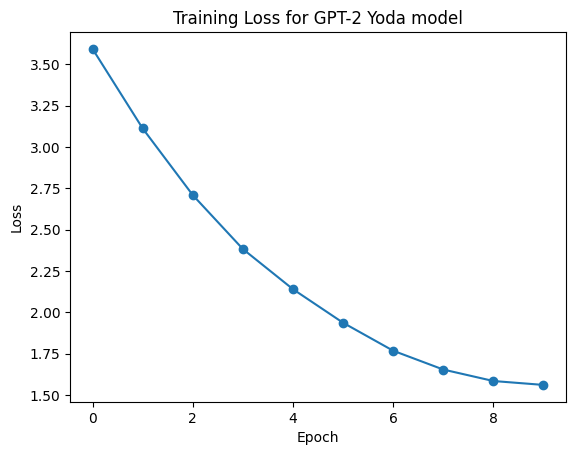

In [33]:
import matplotlib.pyplot as plt

# Make a dataframe of the log history
metrics_df = pd.DataFrame(trainer.state.log_history)

# Plot
metrics_df['eval_loss'].plot(marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for GPT-2 Yoda model')
plt.show()

Finally, we should save our model from memory locally to disk. Later, we'll push the model to the Hugging Face hub:

In [34]:
trainer.save_model()

Now, if we take a look at the folder, we can see the (updated) model weights have been saved locally, as well as the different types of model configuration files that Hugging Face expects. Here, since we set the output directory to be `yoda-distilgpt2` in the `TrainingArguments`, we can find the saved model and files there:

In [35]:
!ls yoda-gpt2

checkpoint-130	config.json  generation_config.json  model.safetensors	training_args.bin


In [36]:
# How big is our model?
!du -h yoda-gpt2/model.safetensors

475M	yoda-gpt2/model.safetensors


### Testing our fine-tuned model
Now that we've done some (very) quick fine-tuning, let's check out the results by reloading the model and generating some text as we covered earlier. Hopefully our tuned GPT-2 model will have taken on some of the qualities of how a Jedi master speaks!

First, we can do this in the most straightforward way using a pipeline:

In [37]:
from transformers import pipeline
from IPython.display import Markdown

# Input
input_text = "Luke, you must know that"

# Load the model into a pipeline, here the argument to is the local path, not the model name on Hugging Face hub
yodagpt2 = pipeline('text-generation',model='./yoda-gpt2', tokenizer=tokenizer, max_length=30)

# Generate the outputs
outputs = yodagpt2(input_text, num_return_sequences=4, do_sample=True, temperature=0.8, top_k=5, top_p=0.9)

# Print
for output in outputs:
  display(Markdown(output['generated_text']))

Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Luke, you must know that the Force is with you. May the Force be with you. May the Force be with you. May the Force be

Luke, you must know that the Force is with you. Protecting your home, it will. The Sith will not. They will. They will

Luke, you must know that I do. I have. Your apprentice, Qui-Gon Jinn, you must train. Your apprentice, Qu

Luke, you must know that you must. Already, you are. Your apprentice, I have. Your apprentice, Qui-Gon Jinn.

That's looking pretty good! But we see a lot of repetition here. Let's try using the tokenizer and model directly, to apply some of the different decoding strategies we learned earlier for more varied outputs:

In [38]:
# You can either reload the model or use it directly from the trainer object
model = trainer.model

# Input
input_text = "Luke, you must know that"

# Generate the model inputs (token ids)
model_inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Create the outputs with sampling
sample_outputs = model.generate(
    **model_inputs,
    max_new_tokens=30,
    do_sample=True,
    temperature=0.8,
    no_repeat_ngram_size=5,
    top_p=0.9,
    top_k=5,
    num_return_sequences=4,
)

# Beam sampling
beam_outputs = model.generate(
    **model_inputs,
    max_new_tokens=30,
    num_beams=5,
    no_repeat_ngram_size=5,
    early_stopping=True,
    num_return_sequences=4,
)

# Iterate over outputs, decode with tokenizer and print
display(Markdown("Sampling"))
display(Markdown("---"))
for output in sample_outputs:
  display(Markdown(tokenizer.decode(output, skip_special_tokens=True)))

display(Markdown("Beam Search"))
display(Markdown("---"))
for output in beam_outputs:
  display(Markdown(tokenizer.decode(output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sampling

---

Luke, you must know that this boy does not know his place in the Force. Not long ago, he trained me. In the Jedi Temple, he trained Darth Vader. But

Luke, you must know that the Jedi are strong. Unfortunate that you have become involved in the dark side of the Force. The loss of your family, your friends and

Luke, you must know that the Force is with you. Protecting your friends and family, I will. May the Force be with you.  Chancellor Palpatine, I

Luke, you must know that I am. I have. Your apprentice, Qui-Gon Jinn, I have. But not your apprentice. Too young, to become one

Beam Search

---

Luke, you must know that the Force is with you. May the Force be with you. Masked by the Force, you have become. May the Force rest in your power

Luke, you must know that the Force is with you. May the Force be with you. Masked by the Force, you have become. May the Force rest in you.

Luke, you must know that the Force is with you. May the Force be with you. May it rest in your power. May it rest on you. May it teach you

Luke, you must know that the Force is with you. May the Force be with you. Masked by the Force, you have become. May the Force rest in your determination

As we'll be moving into the next section, please restart the Colab runtime here to clear RAM and run the cell below:

In [39]:
import torch
from IPython.display import Markdown
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

### Model Quantization and Parameter Efficient Fine-tuning (PEFT)

In this section we will explore two concepts for making working with LLMs more tractable without extensive compute or memory requirements. *Model quantization* and *parameter efficient fine-tuning*.

While the former can be used just to speed up model predictions, or *inference*, it is often used in conjunction with the latter for reducing the computational requirements for training very large models.

#### Model Quantization

 Quantization is a model size reduction technique that loads the model weights in a lower precision than they were originally trained in, resulting in a reduction in the storage and compute costs for the model.

 This can mean taking a model which originally had its weights stored in a high-precision format, such as 32 or 16-bit floating point, and converting them into a lower precision such as 8-bit (or even 4-bit!) integer values.

 Surprisingly, even with this loss of precision, many sophisticated LLMs are still found to perform quite well after quantization.

 Model quantization approaches do not just simply round or truncate the weight values, they are converted using a formula like the below in the [affine quantization scheme](https://pytorch.org/blog/quantization-in-practice/#affine-and-symmetric-quantization-schemes):

 $x_q = round(x/S + Z)$

 where:
 - $x_q$ is the quantized value
 - $x$ is the original value
 - $S$ is the *scale factor*
 - $Z$ is the zero point

Optimal values can all be determined as part of the quantization process in calibration.

There are also well-known more sophisticated approaches for quantization such as [GPT-Q](https://arxiv.org/abs/2210.17323) and [Activation-aware Weight Quantization (AWQ)](https://github.com/mit-han-lab/llm-awq) which have been applied to create qunatized versions of popular models which are highly optimized inference. In the Hugging Face space, Tom Jobbins (*a.k.a* [The Bloke](https://huggingface.co/TheBloke)) is a well-known individual for producing many quantized versions and variations of popular models.

Let's try loading a large version of GPT-2 using qunatization, and then do some inference. Here we will use [GPT2-XL](https://huggingface.co/gpt2-xl), the 1.5B parameter version of GPT-2, which weighs in at ~6.5GB! All we need to do is pass the `load_in_4bit=True` parameter when loading the model to apply quantization:

In [40]:
model_id = "gpt2-xl"

model = AutoModelForCausalLM.from_pretrained(model_id, load_in_4bit=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend


RuntimeError: CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend

In [ ]:
f"{model.num_parameters():,}"

'1,557,611,200'

We can see that each linear layer in the model has been replaced with a 4-bit layer:

In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1600, out_features=4800, bias=True)
          (c_proj): Linear4bit(in_features=1600, out_features=1600, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1600, out_features=6400, bias=True)
          (c_proj): Linear4bit(in_features=6400, out_features=1600, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, element

Now, let's generate some text. We know how to do this now, so leverage some of our earlier code from before, using temperature and top-p sampling:

In [ ]:
# Generate the model inputs (token ids)
input_text = "The rain in Spain"

model_inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Create the outputs with sampling
sample_outputs = model.generate(
    **model_inputs,
    max_new_tokens=30,
    do_sample=True,
    temperature=0.8,
    no_repeat_ngram_size=5,
    top_p=0.9,
    top_k=5,
    num_return_sequences=3,
)

# Iterate over outputs, decode with tokenizer and print
for output in sample_outputs:
  display(Markdown(tokenizer.decode(output, skip_special_tokens=True)))
  display(Markdown("---"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


The rain in Spain, which is now in its third day, has brought down some of the worst flooding the country has seen for a century.

In the capital

---

The rain in Spain is not a problem, as long as the wind is not strong. The wind is strong enough to make it a problem for some people, and it

---

The rain in Spain is a lot more than the rain in the US," he says. "It's a very different experience."

The Spanish weather is so unpredictable

---

Great! We can now efficiently perform inference using very large LLMS via quantization 👍 You can read more about loading quantized models in the Hugging Face documentation here: [Quantize 🤗 Transformers models](https://huggingface.co/docs/transformers/main_classes/quantization)

#### Fine-tuning a quantized LLM using PEFT

Now that we have sucessfully loaded a very large transformer model, let's move on to seeing how we can fine tune it using a parameter efficient fine-tuning, or [PEFT](https://github.com/huggingface/peft), approach.

Luckily for us this is easy to do in Hugging Face using the `peft` library which we installed at the beginning of this notebook.

Here we will fine-tune a quantized version of GPT2-XL using [Low Rank Adaption (LoRA)](https://github.com/microsoft/LoRA). This approach was first introduced by researchers from Microsoft in 2021.

Instead of updating all the weights in a model, LoRA is a reparameterization method that introduces a smaller number new weights via two matrices which decompose the weights into a lower rank representation, and only these weights are updated during the training process.<br/><br/>

<center>
<img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/lora.png?raw=1" width="50%"/>
</center>
<center>
<caption> Diagram of LoRA, from the original paper </caption>
</center>

Luckily, this is all easy enough to do as it is implemented in Hugging Face in the `peft` library.

First, we need to prepare the model for quantized training:

In [ ]:
from peft import prepare_model_for_kbit_training

# Reload the quantized model and tokenizer
#model = AutoModelForCausalLM.from_pretrained("gpt2-xl", load_in_4bit=True)
#tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
tokenizer.pad_token = tokenizer.eos_token

# Enable ch
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Then, we import a [LoRA configuration](https://huggingface.co/docs/peft/conceptual_guides/lora#common-lora-parameters-in-peft), and then apply it to the model to use LoRA in fine-tuning:

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config).to(device)

Using this utility function, we can take a look at the number of parameters in the model which will be updated as part of the fine-tuning:

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model)

trainable params: 2,457,600 || all params: 822,788,800 || trainable%: 0.2986914746530337


We can see that total number of parameters counted here has been greatly reduced, this is due to the model weights being loaded in 4-bit as part of quantization. The total number of trainable parameters with LoRA here is still ~2.5M.

Now that the model is set up with LoRA, the remaining steps are the same as for regular fine-tuning! We import the data, set up a training configuration and `Trainer` object, and the start the fine-tuning:

In [ ]:
from datasets import load_dataset
# 1. Load dataset and tokenize
data_files = {"train": "yoda.csv"}
dataset_name = 'datasets/yoda/'
dataset = load_dataset(dataset_name, data_files=data_files)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(data):
    my_tokenizer = tokenizer(data["text"], padding=True, truncation=True, return_tensors="pt", max_length=128)
    return my_tokenizer

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Repo card metadata block was not found. Setting CardData to empty.


Map:   0%|          | 0/103 [00:00<?, ? examples/s]

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

# Set up the training arguments
training_args = TrainingArguments(
        output_dir="yoda-gpt2xl-lora",
        num_train_epochs=10,
        fp16=True,
        optim="paged_adamw_8bit",
        report_to="none"
    )

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Trainer
trainer = Trainer(
    model=model,
    train_dataset=tokenized_dataset["train"],
    args=training_args,
    data_collator=data_collator,
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=130, training_loss=3.930248319185697, metrics={'train_runtime': 85.3085, 'train_samples_per_second': 12.074, 'train_steps_per_second': 1.524, 'total_flos': 429305456832000.0, 'train_loss': 3.930248319185697, 'epoch': 10.0})

Now let's test it out:

In [ ]:
input_text = "Luke, you must know that "

model_inputs = tokenizer(input_text, return_tensors="pt").to(device)

# Create the outputs with sampling
outputs = trainer.model.generate(
    **model_inputs,
    max_new_tokens=30,
    do_sample=True,
    no_repeat_ngram_size=2,
    temperature=0.8,
    top_p=0.95,
    top_k=5,
    num_return_sequences=4,
)

# Iterate over outputs, decode with tokenizer and print
display(Markdown("---"))
for output in outputs:
  display(Markdown(tokenizer.decode(output, skip_special_tokens=True)))
  display(Markdown("---"))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


---

Luke, you must know that!"

"Yes, I do," he said, "but it's not the same as knowing the truth. I've been told of the

---

Luke, you must know that  I am Luke Skywalker.   I am the Jedi, and I will be.  
Luke Skywalker,  Luke,   the  you

---

Luke, you must know that?" He was a man of the people. The words he spoke had a strange ring to them, as if they had been spoken before. "It

---

Luke, you must know that!"

"I am not a Jedi. You must be." ―Luke Skywalker and Palpatine, on the same battlefield [src]


---

Great! With just a few epochs of training, we seem to have significantly altered the behavior of the model as before, only with tuning a much smaller subset of parameters, making it feasible with the computing resources we have available.

To eliminate latency in inference and use the model as a standalone model without LoRA, we can [merge the adapter weights back into the base model](https://huggingface.co/docs/peft/conceptual_guides/lora#merge-lora-weights-into-the-base-model). This should be done before pushing the model to the Hub if you wish to use the model as a standalone model.

<center>
<img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/lora_merge.png?raw=1">
</center>
<center>
<caption> Merging the adapter weights </caption>
</center>

In [ ]:
# Model is a PEFT model
model.__class__

peft.peft_model.PeftModelForCausalLM

In [ ]:
# Merge the LoRA weights back into the model
merged_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
# Merged model is of same type as base model
merged_model.__class__

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

### Further optimizing LoRA: QLoRA

Building on the work of the research of the team at Microsoft, researchers from University of Washington developed [QLoRA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314) in May of 2023.

[QLoRA](https://github.com/artidoro/qlora) makes parameter efficient fine-tuning even more so by using 4-bit quantization for the model to be tuned, introducing a new data type called 4-bit NormalFloat (NF4), and using "double quantization", where the quantization parameters are also quantized.

This can be accomplished in code by using a `bitsandbytes` config and with the following parameters:

```python
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

...
model = AutoModelForCausalLM.from_pretrained(
  "gpt2-xl",
  quantization_config=bnb_config
  )

```

You can see an example of using QLoRA in Hugging Face [in this example notebook](https://colab.research.google.com/drive/1VoYNfYDKcKRQRor98Zbf2-9VQTtGJ24k?usp=sharing) and more details in the [official blog post](https://huggingface.co/blog/4bit-transformers-bitsandbytes) from Hugging Face.

A notable output of the QLoRA research was that of the [Guanco model](https://huggingface.co/spaces/uwnlp/guanaco-playground-tgi) family which was fine-tuned on LLaMA 2.

## Conclusion 🏁

We have covered a lot of ground in both working with generative large language models for inference, as well as methods for efficiently fine-tuning them with limited computational resources. However, we have really just scratched the surface of LLMs for text, and there is much more that makes up the incredibly sophisticated models which represent the state of the art.

- **Training "chat" models**: By changing the [format of the input](https://huggingface.co/docs/transformers/main/en/chat_templating) and prediction task, and applying more sophisticated approaches such as [instruction tuning](https://arxiv.org/abs/2308.10792).
- **Reinforcement learning from human feedback (RLHF)**: Now a standard part of LLM development but is non-trivial for the individual. However, this is possible to do with a base model and the right datasets using the [trl library](https://huggingface.co/docs/trl/index).
- **Retrieval Augmented Generation**: Or [RAG](https://proceedings.neurips.cc/paper/2020/hash/6b493230205f780e1bc26945df7481e5-Abstract.html), for combining the generative capabilities of LLMs with search and retrieval from a datastore, to reduce "hallucinations" and be able to have a language model work against a knowledge base.

LLMs represent the state of the art in generative text models and have rapidly transformed this space (and many other domains) in a very short order. Knowing how how they function, how to use them, and being aware of their shortcomings allows them to be judiciously applied to the right use cases to unlock business value and build product of value to the end-user.

----

<table border="0" bgcolor="white">
  <tr></tr>
  <tr>
      <th align="left" style="align:left; vertical-align: bottom;"><p>Copyright NLP from scratch, 2025.</p></th>
      <th aligh="right" width="33%"><a href="https://www.nlpfromscratch.com?utm_source=notebook&utm_medium=nb-footer-img"><img src="https://github.com/nlpfromscratch/nlpfromscratch.github.io/blob/main/Microcourses/llmsfor.me/assets/banner.png?raw=1"></th>
</tr>
</table>